# Workflow to calculate the quantum efficiency of a polycrystalline material

In [1]:
import subprocess
import os
from ase.io import read
from ase.visualize import view
from ase.build import surface
import ase.calculators.castep
import ase.io.castep


from pymatgen.core.structure import Structure
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.electronic_structure.bandstructure import BandStructureSymmLine
from pymatgen.symmetry.kpath import KPathSetyawanCurtarolo,KPathLatimerMunro
from pymatgen.electronic_structure.dos import *
from pymatgen.electronic_structure.plotter import BSPlotter
from python_functions import *
from bs_plotting import *
import json
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
directory = './structures/Cu_surf_111/'
work_fct = 3.52958434
listOfFiles = os.listdir(directory)
for item in listOfFiles:
    if '_photo.odi' in item:
        subprocess.call(f'sed -i "s/.*work_function.*/workfunction : {round(work_fct,5)}/" {directory}{item}',shell=True)
#subprocess.call(,)
#f'sed -i "s/.*work_function.*/workfunction : {round(work_fct,5)}/" {directory}{item}'
#f'sed -i "s/.*slab_volume.*/slab_volume : {round(slab_vol,5)}/" {path}{item}'

In [ ]:
cell = read_cell2pmg('./structures/Cu_surf_111_bak/Cu_surf_111_geom.cell')
#cell = CastepOutput('./structures/Cu_surf_111/Cu_surf_111.castep').structure
print(cell)

In [ ]:
view(AseAtomsAdaptor.get_atoms(cell))

In [ ]:
file_path = './structures/Cu_surf_111_photo/Cu_surf_111.castep'
output = CastepOutput(file_path)#
print(output.structure)

In [ ]:
seed = 'Cu_bulk_spectral_pdos'
seed = 'Cu_surf_111'
eins, axis = plot_proj_dos_optados(seed, plot_down= False, plot_total= False, export_json=False,xlimit=(-10, 10))
plt.savefig('Cu111_pdos_-10_10.png',dpi=200)

In [ ]:
struct_110 = AseAtomsAdaptor.get_structure(read('./structures/Cu_surf_110/Cu_surf_110.xyz'))
latimer = KPathLatimerMunro(struct_110)
for index in range(12):
    print('Latimer_Munroe Label:', latimer.LabelSymbol(index),'Point: ', latimer.LabelPoints(index))
print('SetyawanCurtarolo/ASE',KPathSetyawanCurtarolo(struct_110).orc())

I recommend using pymatgen to generate the bulk/slab and then convert it to an ASE atom object. The advantages of this approach are:
- pymatgen has a better bulk/slab generation algorithm 
- castep can link a calculator to the Atom object


#### Download and save .cif file for necessary materials

In [ ]:
bulk = Structure.from_file(filename="Cu_metal_fcc.cif")
# print(bulk)
# print(bulk.volume)
# print(bulk.lattice)
# print(bulk.species)
# print(bulk.sites)
bulk_ase = AseAtomsAdaptor().get_atoms(bulk)
# print(bulk_ase)
# print(bulk)
surface = ase.build.surface(lattice = bulk_ase, indices = (1,1,1), layers = 5, vacuum=15, tol=1e-10, periodic=True)
print(get_adjusted_kpts(bulk,AseAtomsAdaptor.get_structure(surface), [9,9,9] ))
view.add_unitcell()
view

In [ ]:
surf_110 = read_cell2pmg('./structures/Cu_surfaces_debug/Cu_surf_110.cell')
view(AseAtomsAdaptor.get_atoms(surf_110))
surf_100 = read_cell2pmg('./structures/Cu_surfaces_debug/Cu_surf_100.cell')
view(AseAtomsAdaptor.get_atoms(surf_100))

#### Read the Cutoff Energy Results and Display as Graph

{'pbe': [17.466488748999836, 1.0880801920000067, 0.03742445700004282, 9.470300005887111e-05, 5.178399987926241e-05], 'pbesol': [17.46648882799991, 1.0880801910000173, 0.03742445300008512, 7.702800007791666e-05, 6.946099983906606e-05]}


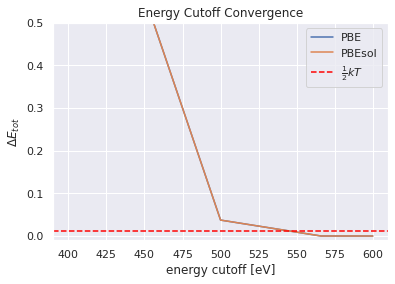

In [13]:
seed = 'Cu_bulk_'
path_pbe = './structures/Cu_bulk_convergence/cutoff/'
path_sol = './structures/Cu_bulk_convergence/cutoff/PBEsol/'
cutoffs = [200, 300, 400, 500, 566, 600]
tot_energies, differences = {'pbe' : [],'pbesol' : []},{'pbe' : [],'pbesol' : []}
for cut in cutoffs:
    temp_pbe = CastepOutput(path = f'{path_pbe}{seed}{cut}/{seed}{cut}.castep')
    temp_sol = CastepOutput(path= f'{path_sol}{seed}{cut}/{seed}{cut}.castep')
    tot_energies['pbe'].append(temp_pbe.ks_total_energy)
    tot_energies['pbesol'].append(temp_sol.ks_total_energy)

for i in range(1,len(cutoffs)):
    differences['pbe'].append(abs(tot_energies['pbe'][i]-tot_energies['pbe'][i-1]))
    differences['pbesol'].append(abs(tot_energies['pbesol'][i]-tot_energies['pbesol'][i-1]))

#print('Differences:', differences)
#print('Total Energies:', tot_energies)
#plt.rcParams['text.usetex'] = True
sns.set_theme(style="darkgrid")
# Plot the responses for different events and regions
print(differences)
graph = sns.lineplot(x=cutoffs[1:], y=differences['pbe'])
graph = sns.lineplot(x=cutoffs[1:], y=differences['pbesol'])
graph.axhline(0.01285, ls = '--', c = 'red')
graph.set(xlabel = 'energy cutoff [eV]', ylabel = r'$\Delta E_{tot}$', title = 'Energy Cutoff Convergence')
graph.set(xlim = (390,610), ylim =  (-0.01,0.5))
plt.legend(labels=[r'PBE','PBEsol',r'$\frac{1}{2}kT$'])
plt.savefig('./structures/plots/convergence_comparison_cutoff_zoom.png')

In [10]:
subprocess.call('qstat', shell=True)

Job id            Name             User              Time Use S Queue
----------------  ---------------- ----------------  -------- - -----
5859925.pbs       Cu_bulk_600      fcm19                    0 Q v1_short8       
5860085.pbs       jupyterhub       fcm19             00:00:06 R pqinteractive   


0

{'pbe': [0.629629193000028, 0.05627917400011029, 0.01288908900005481, 0.012433453999847188, 0.011882805999903212, 0.0015837030000511731, 0.0005678719999195891, 0.00011995999989267148, 0.0001996649998545763], 'pbesol': [0.6274421550001534, 0.05716377699991426, 0.012748325000075056, 0.012380637999967803, 0.012008241000103226, 0.001480593999986013, 0.0005344349999631959, 0.0001393560000906291, 0.00019317300007060112]}


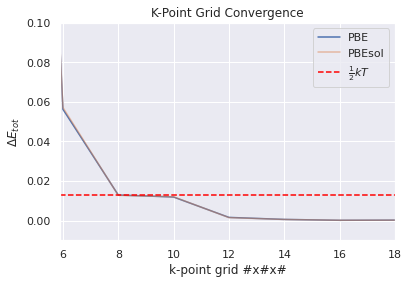

In [17]:
seed = 'Cu_bulk_'
path_pbe = './structures/Cu_bulk_convergence/k_points/'
path_sol = './structures/Cu_bulk_convergence/k_points/PBEsol/'
cutoffs = [2,4,6,8,9,10,12,14,16,18]
tot_energies, differences = {'pbe' : [],'pbesol' : []},{'pbe' : [],'pbesol' : []}
for cut in cutoffs:
    temp_pbe = CastepOutput(path = f'{path_pbe}{seed}{cut}/{seed}{cut}.castep')
    temp_sol = CastepOutput(path= f'{path_sol}{seed}{cut}/{seed}{cut}.castep')
    tot_energies['pbe'].append(temp_pbe.ks_total_energy)
    tot_energies['pbesol'].append(temp_sol.ks_total_energy)

for i in range(1,len(cutoffs)):
    differences['pbe'].append(abs(tot_energies['pbe'][i]-tot_energies['pbe'][i-1]))
    differences['pbesol'].append(abs(tot_energies['pbesol'][i]-tot_energies['pbesol'][i-1]))

#print('Differences:', differences)
#print('Total Energies:', tot_energies)
#plt.rcParams['text.usetex'] = True
sns.set_theme(style="darkgrid")
# Plot the responses for different events and regions
print(differences)
graph = sns.lineplot(x=cutoffs[1:], y=differences['pbe'])
graph = sns.lineplot(x=cutoffs[1:], y=differences['pbesol'],alpha = 0.5)
graph.axhline(0.01285, ls = '--', c = 'red')
graph.set(xlabel = 'k-point grid #x#x#', ylabel = r'$\Delta E_{tot}$', title = 'K-Point Grid Convergence')
graph.set(xlim = (5.9,18), ylim =  (-0.01,0.1))
plt.legend(labels=[r'PBE','PBEsol',r'$\frac{1}{2}kT$'])
plt.savefig('./structures/plots/comparison_kpoints_zoom.png',dpi = 250)

#### Create scaled volume inputs, read the output files and create murnaghan plot

In [ ]:
bulk = Structure.from_file(filename="Cu_metal_fcc.cif")
create_murnaghan_inputs(seed = 'Cu_bulk_murn', structure=bulk, cutoff = 600, kpoints=[16,16,16], min_max=(0.9,1.1,10))

In [ ]:
bulk = Structure.from_file(filename="Cu_metal_fcc.cif")
seed = 'Cu_bulk_murn_ext'
murn, minimal_struct, energies,volumes = read_murnaghan_outputs(seed = seed, structure = bulk,path = f'./structures/EOS_tests/PBEsol/{seed}/')
fig= murn.plot()
plt.style.use('seaborn-darkgrid')
#plt.savefig(f'./structures/plots/{seed}_pbesol.png')

#### Read the Results for Kpoint grid convergence and plot as graph

ToDo: Modify the Kpoint convergence generation function to make a single input and then vary the values within the PBS script

In [ ]:
seeds = ['Cu_bulk_2','Cu_bulk_4','Cu_bulk_6','Cu_bulk_8','Cu_bulk_9','Cu_bulk_10','Cu_bulk_12','Cu_bulk_14','Cu_bulk_16','Cu_bulk_18']
tot_energies = []
differences = []
kpoints = [4,6,8,9,10,12,14,16,18]
kpoints2 = kpoints[1:]
for seed in seeds:
    temp_out = CastepOutput(path = f'./structures/kpt_convergence/{seed}.castep')
    tot_energies.append(temp_out.ks_total_energy)
for i in range(len(tot_energies)):
    if i == 0:
        pass
    if i == len(tot_energies)-1:
        break
    differences.append(abs(tot_energies[i+1]-tot_energies[i]))
sns.set_theme(style="darkgrid")
differences_2 = differences[1:]
#print(differences_2)
# Plot the responses for different events and regions
graph = sns.lineplot(x=kpoints2, y=differences_2)
graph.axhline(0.01285, ls = '--', c = 'red')
graph.set(xlabel = 'MP k-point grid size (x,x,x)', ylabel = r'$\Delta E_{tot}$ [eV]', title = 'K-point Grid Convergence')
plt.legend(labels=[r'$\Delta$ E',r'$\frac{1}{2}kT$'])
#plt.savefig('./structures/plots/k_point_convergence_zoom.png',dpi = 300)

#### Read in the geometry optimisation trajectory file

In [ ]:
from pymatgen.core.lattice import Lattice
from pymatgen.core.structure import Structure

data = read_geometry_traj_file(path = './structures/')

#### Plot the electronic densities and potential

In [ ]:
fig,ax = create_density_plot(directory = './structures/Cu110_victor_60A/', centered = False)
plt.tight_layout()
plt.savefig('./structures/plots/Cu110_victor_60A_density_plot.png')

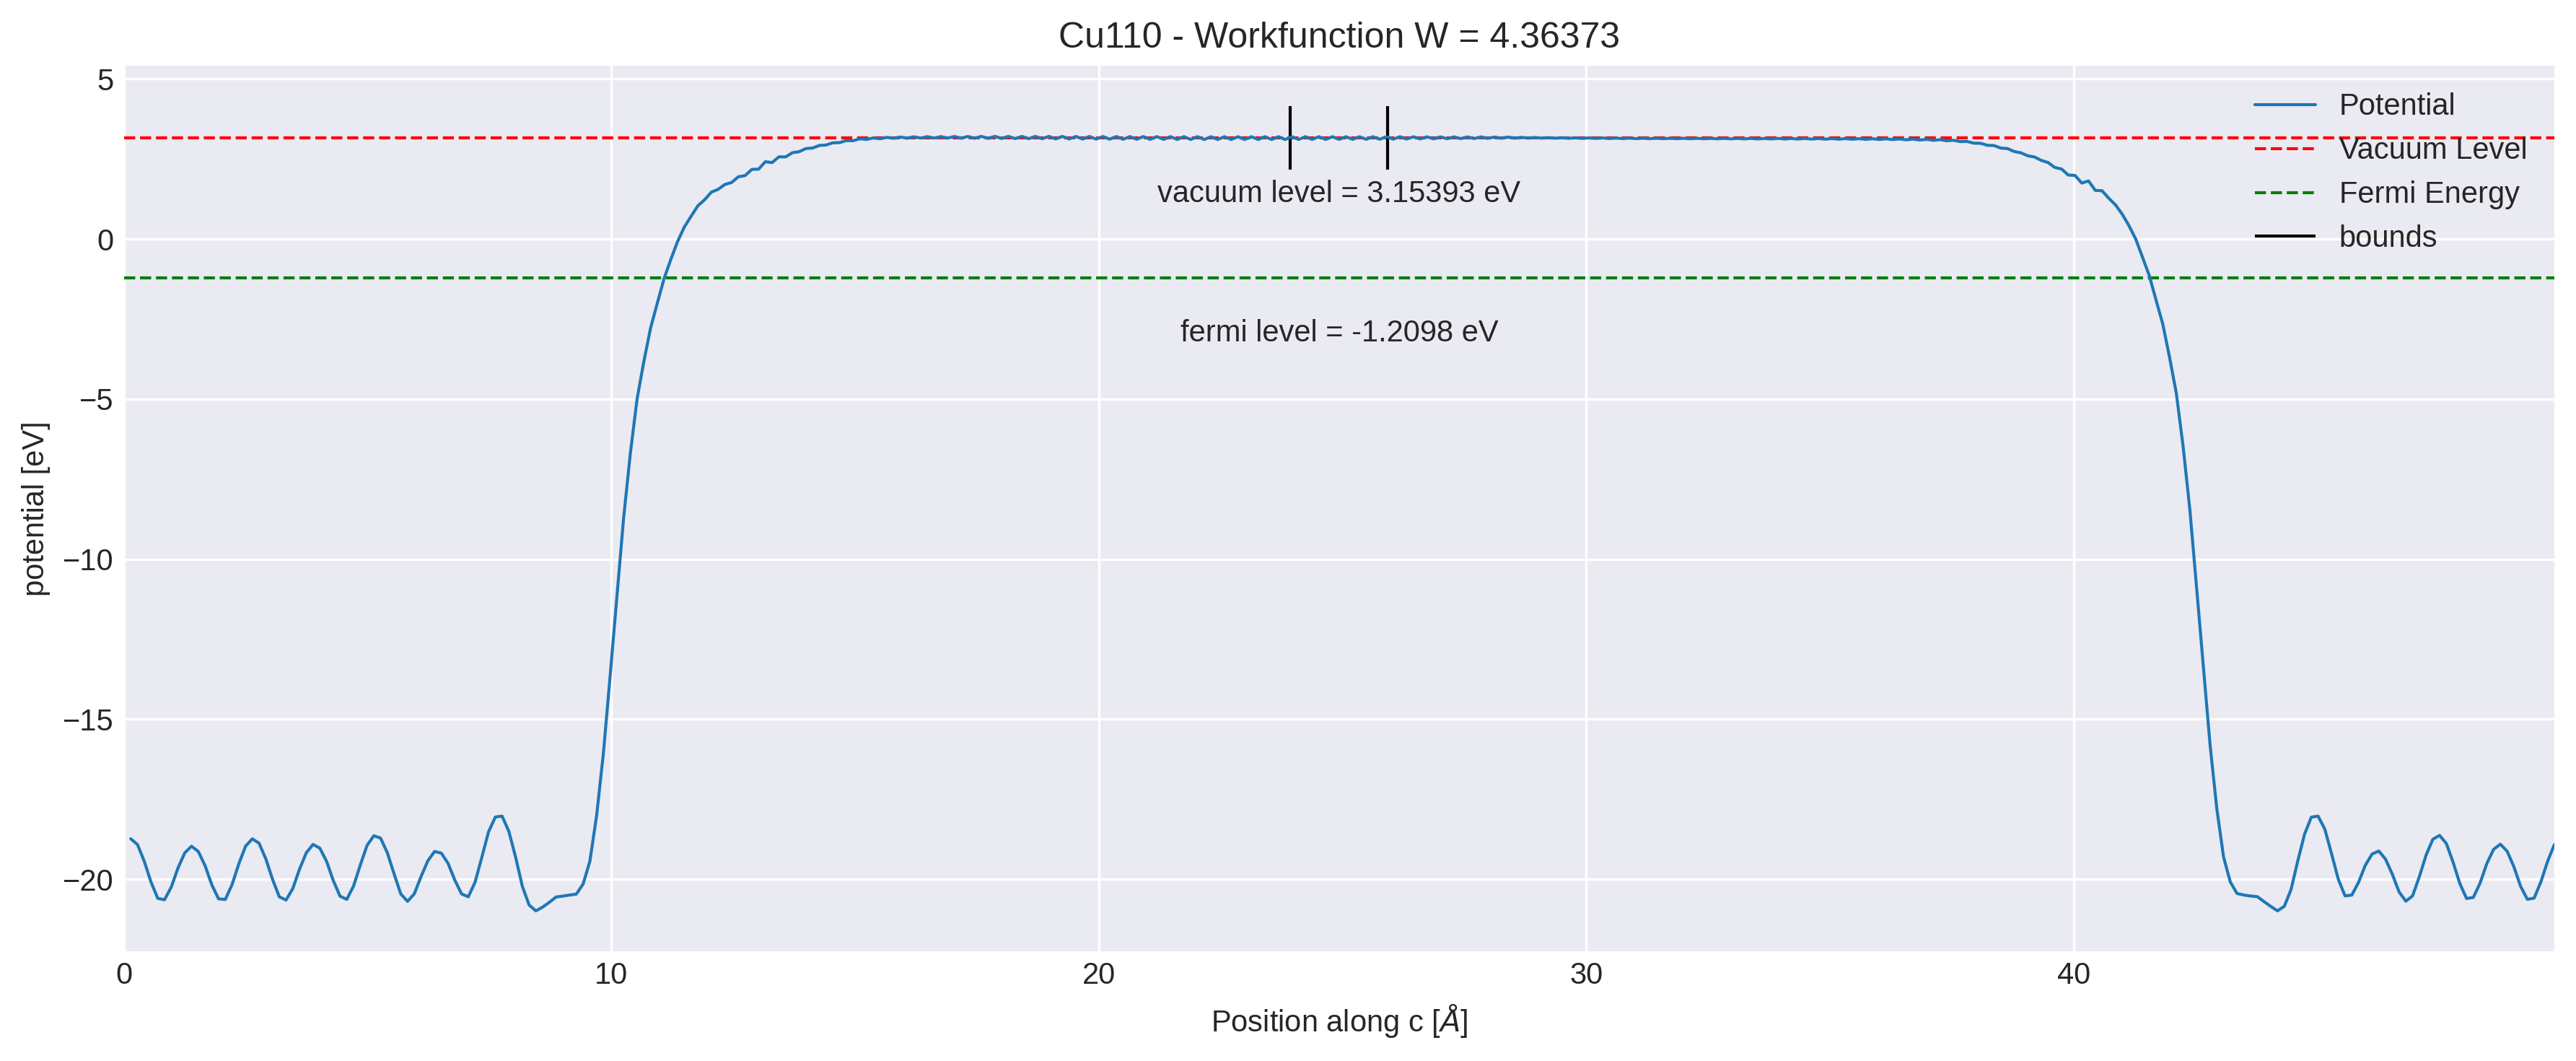

In [5]:
fig,ax = create_potential_plot(directory='./structures/Cu110_victor_50A/14L/', centered = False)
plt.tight_layout()
plt.savefig(f'./structures/plots/Cu110_pbesol_14L_50A_potential_plot.png')

#### Create Plot with modified pymatgen functions to create more colourful bandstructure plot

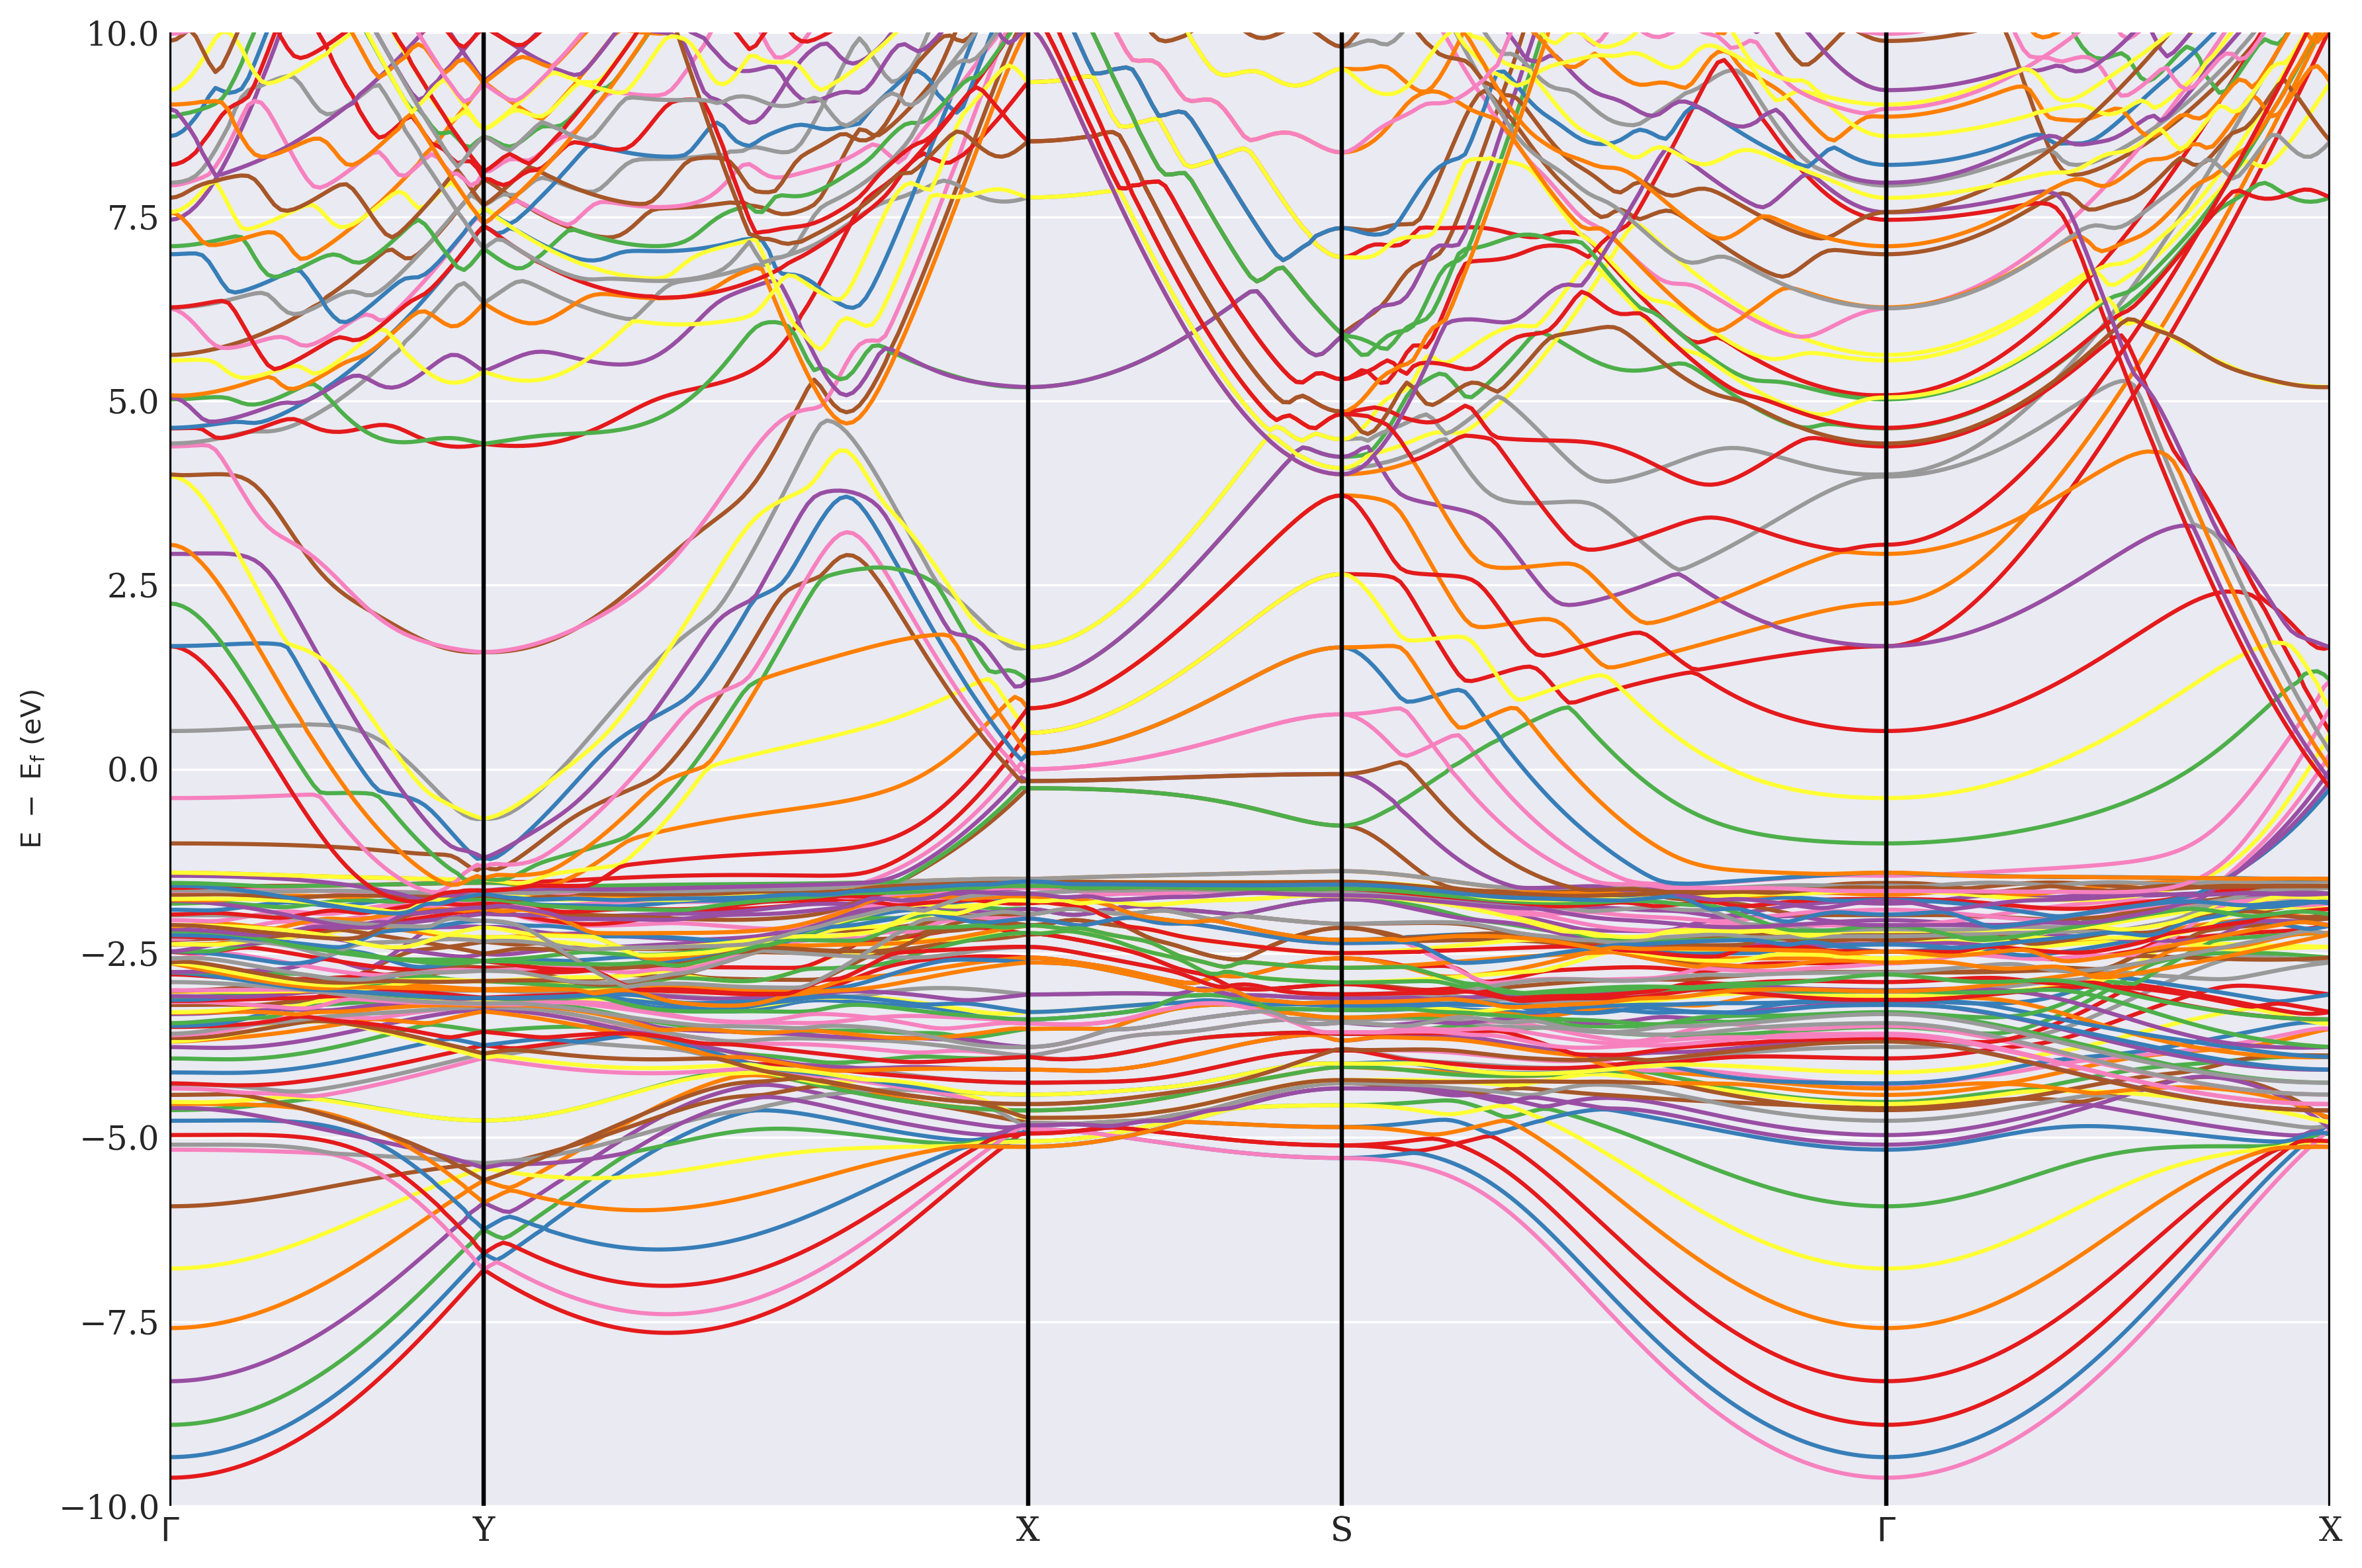

In [4]:
%matplotlib inline
bandstructure_cu = read_bands2pmg(path='./structures/Cu110_victor_60A', export=False)
#print(bandstructure_cu.distance)
output = []
for kpt in bandstructure_cu.kpoints:
    output.append((kpt.label,kpt.cart_coords))
plot = get_bs_plot(bandstructure_cu,ylim = (-10,10))

plt.savefig('./structures/plots/Cu110_victor_60_bandstruct.png',dpi=300)

#### Plot reference Cu Bandstructure from Materials Project 

In [ ]:
with open('./structures/band_jsons/Cu_bandstruct_ref.json', 'r') as f:
    d = json.load(f)
    bandstruct_new = BandStructureSymmLine.from_dict(d)

plotter = BSPlotter(bandstruct_new)
#print(bandstruct_new.as_dict()['branches'])
#print(bandstruct_new.get_branch(320))
band_plot = plotter.get_plot(ylim=(-5,9))
band_plot.show()

#### Plot bandstructure from castep .bands file using ASE functions

In [ ]:
#bandfile = create_bands_file(calc_struct = AseAtomsAdaptor().get_atoms(Structure.from_file(filename="Fe_metal_bcc.cif")),seed = 'Fe')
seed = 'Cu_bulk_bandstruct'
calc_struct = AseAtomsAdaptor().get_atoms(Structure.from_file(filename="Cu_metal_fcc.cif"))
calc = ase.calculators.castep.Castep(check_castep_version = False,keyword_tolerance=3)
calc_struct.calc = calc
bandstructure = calc_struct.calc.band_structure(bandfile=f'./structures/{seed}/{seed}.bands').subtract_reference()
#print(bandstructure.get_labels())
plt.style.use('seaborn')
#ax.ylimit(-12,35)
bandstructure.plot(emin=-12, emax=35)

#### Create Parameter Sweep for OptaDOS

In [2]:
photoemission_options= {
        'work_function' : 4.3731,
        'surface_area' : 6.55677,
        'slab_volume' : 198.13882,
        'elec_field' : 0,
        'optics_qdir' : [1, 1.000, 1.0000],
        'photo_model' : ['1step','3step'] # 1step or 3step or 1step,3step
}
optados_photon_energy_sweep(seed='Cu_surf_110', min_max = (4,5.5,20), **photoemission_options)

In [4]:
one = [1,2,3,4]
print(' '.join([str(x) for x in one]))

1 2 3 4


#### Read in the photon energy sweep output files

In [ ]:
Cu_surf_data = read_photonsweep_outputs(seed = 'Cu_surf_100', path = './structures/Cu_surf_100_victor_60A/')
graph_options = {
    'title': 'Cu[100]',
    'temperature': 298,
    'filename' : './structures/plots/Cu100_victor_50A_mte_plot_0E.png'
}
#print(Cu_111_data)
fig, ax = make_photonsweep_plots(Cu_surf_data,**graph_options)
plt.savefig(graph_options['filename'],dpi = 250)

In [ ]:
Cu_surf_data = read_photonsweep_outputs(seed = 'Cu_surf_111', path = './structures/Cu_surf_111/')
graph_options = {
    'title': 'Cu[111]',
    'temperature': 298,
    'filename' : './structures/plots/Cu_111_pbesol_120deg_test2_mte_plot_0E.png'
}
#print(Cu_111_data)
fig, ax = make_photonsweep_plots(Cu_surf_data,**graph_options)
plt.savefig(graph_options['filename'],dpi = 250)

### Plot DOS plot created by OptaDOS

In [ ]:
seed = 'Cu_surf_111'
fig, ax= plot_dos_optados(seed, plot_total = False, xlimit = (-12, 35), export_json = False)
#plt.savefig(f"./structures/plots/{seed}_dos.png")

### Plot proj DOS plot created by OptaDOS

In [ ]:
#seed = 'Cu_bulk_spectral_pdos'
path='./structures/Cu_surf_111_victor_50A/'
eins, axis = plot_proj_dos_optados(path = path, plot_down= False, plot_total= False, export_json=False,xlimit=(-10, 10))
plt.title('Cu[111] projected DOS')
plt.xlabel('Energy [eV]')
plt.ylabel('pDOS [arb.u.]')
plt.tight_layout()
plt.savefig('./structures/plots/Cu111_victor_50A_-10_10.png',dpi=200)

### Plot joint DOS created by OptaDOS

In [ ]:
data_10060 = get_joint_dos_optados('./structures/Cu_surf_100_victor_60A/')
label_1 = 'Cu100_60A'
data_10050 = get_joint_dos_optados('./structures/Cu110_victor_60A/')
label_2 = 'Cu110_60A'
data_11160 = get_joint_dos_optados('./structures/Cu_surf_111_victor_60A/')
label_3= 'Cu111_60A'
fig,ax = plot_joint_dos_optados(data_10060, label=label_1, xlimit =[0,6])
fig,ax = add_jdos_line(data_10050,fig,ax,label=label_2)
fig,ax = add_jdos_line(data_11160,fig,ax,label=label_3)
ax.set_title('Joint DOS for Cu')
plt.legend()
plt.savefig('./structures/plots/Cu_jdos_comparison_6.png')

In [ ]:
data_11160 = get_joint_dos_optados('./structures/Cu_surf_111_victor_60A/')
label_1 = 'Cu111_60A'
data_11150 = get_joint_dos_optados('./structures/Cu_surf_111_victor_50A/')
label_2 = 'Cu111_50A'
fig,ax = plot_joint_dos_optados(data_11160, label=label_1, xlimit =[0,6])
fig,ax = add_jdos_line(data_11150,fig,ax,label=label_2)
ax.set_title('Joint DOS for Cu[111]')
plt.legend()
plt.savefig('./structures/plots/Cu111_jdos_comparison.png')

## Plot DOS from json files

In [ ]:
from pymatgen.electronic_structure.plotter import DosPlotter
with open('./structures/jsons/DOS/Cu_bulk_spectral_dos_total.json', 'r') as f:
   d = json.load(f)
   dos_calc = Dos.from_dict(d)
with open('./structures/jsons/DOS/Cu_bulk_matproject_ref.json', 'r') as f:
    d = json.load(f)
    dos_ref = Dos.from_dict(d)
plt.style.use('seaborn-darkgrid')
plotter = DosPlotter()
plotter.add_dos("calculated", dos_calc)
plotter.add_dos("reference", dos_ref)
plotter.get_plot(xlim = (-12,2.5),ylim=(-0.2,9))
plt.savefig('./structures/plots/Cu_bulk_tot_dos_comparison_dos_matproj_zoom.png')

In [ ]:
with open('./structures/jsons/bands/Cu_bulk_bandstruct_full.json', 'r') as f:
    d = json.load(f)
    bandstruct_cu_full = BandStructureSymmLine.from_dict(d)
with open('./structures/jsons/bands/Cu_bulk_bandstruct_full_UX.json', 'r') as f:
   d = json.load(f)
   bandstruct_cu_ux = BandStructureSymmLine.from_dict(d)
bandstruct_full = append_symm_line(bandstruct_cu_full,bandstruct_cu_ux)
with open(f'./structures/band_jsons/cu_bandstruct_all_points.json', 'w') as f:
    json.dump(bandstruct_full.as_dict(), f)
plotter = BSPlotter(bandstruct_full)
band_plot = plotter.get_plot(ylim=(-5,9))
band_plot.show()

In [ ]:
with open('./structures/jsons/bands/Cu_bandstruct_ref.json', 'r') as f:
    d = json.load(f)
    bandstruct_cu_ref = BandStructureSymmLine.from_dict(d)
with open('./structures/jsons/bands/cu_bandstruct_all_points.json', 'r') as f:
   d = json.load(f)
   bandstruct_cu_full = BandStructureSymmLine.from_dict(d)

#bandstruct_full = append_symm_line(bandstruct_cu_full,bandstruct_cu_ux)
#with open(f'./structures/band_jsons/cu_bandstruct_all_points.json', 'w') as f:
#    json.dump(bandstruct_full.as_dict(), f)

plotter = BSPlotter(bandstruct_cu_full)
plotter.add_bs(bandstruct_cu_ref)
band_plot = plotter.get_plot(ylim=(-12,35), bs_labels=['Calculated','Materials Project Ref'])
plt.xlabel('')
plt.savefig('comparison_calculated_vs_matproj_ref_optados_Efermi.png')
band_plot.show()
